In [2]:
import numpy as np
import random
import pandas as pd

def log_likelihood(Z_n, omega_n, R, C, sigma):
    """
    Calculates the likelihood of observing the measured impedance data given 
    a specific circuit model and its parameters.

    Args:
        Z_i (complex): Measured impedance at frequency omega_i.
        omega_i (float): Angular frequency.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Likelihood value.
    """
    
    # Calculate impedance from the circuit model
    z_omega_i = circuit_impedance(omega_n, R, C)
    log_likelihood_value = -(1 / (2 * sigma**2)) * abs(Z_n - z_omega_i)**2 - 0.5 * np.log(2 * np.pi * sigma**2)

    return log_likelihood_value  # Return the log-likelihood

def circuit_impedance(omega_n, R, C):
    """
    Calculates the impedance of the circuit model at given frequencies.

    Args:
        omega_n (list or numpy array): Angular frequencies.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.

    Returns:
        numpy array: Impedances of the circuit model for each frequency.
    """
    
    # omega_n = np.array(omega_n)  # Convert to NumPy array for vectorization
    # R = np.array(R)
    # C = np.array(C)
    z_omega_n = np.zeros_like(omega_n, dtype=complex)  # Initialize an array to store impedances

    for i in range(len(R)):
        z_omega_n += R[i] / (1 + 1j * omega_n * R[i] * C[i])  # Vectorized calculation

    return z_omega_n

def log_prior(R, C, R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Calculates the prior probability of the circuit parameters.

    Args:
        R (list): List of resistance values.
        C (list): List of capacitance values.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        float: Prior probability value.
    """
    
    for r in R:
        if not (R_min <= r <= R_max):
            return -np.inf  # Prior is 0 if resistance is outside the allowed range
    for c in C:
        if not (C_min <= c <= C_max):
            return -np.inf  # Prior is 0 if capacitance is outside the allowed range
    
    # If all parameters are within the allowed range, use uniform prior
    return 0  # Log of a uniform distribution is 0  

def log_posterior(omega_n, Z_n, K, R, C, sigma):
    """
    Calculates the posterior probability of the circuit parameters given the 
    observed data and the prior.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R (list): List of resistance values.
        C (list): List of capacitance values.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Posterior probability value.
    """   
    log_prior_prob = log_prior(R, C)
    if log_prior_prob == -np.inf:
        return -np.inf  # If log-prior is -inf, log-posterior is also -inf

    log_likelihood_prob = 0
    
    log_likelihood_prob += np.sum(log_likelihood(Z_n, omega_n, R, C, sigma))

    log_posterior_prob = log_likelihood_prob + log_prior_prob
    return log_posterior_prob  # Return the un-logged posterior probability


def metropolis(omega_n, Z_n, K, sigma, n_iterations=10000, burn_in=1000, 
              R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Performs Metropolis sampling to estimate the circuit parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        sigma (float): Standard deviation of the measurement noise.
        n_iterations (int, optional): Number of MCMC iterations. Defaults to 10000.
        burn_in (int, optional): Number of initial samples to discard. Defaults to 1000.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        tuple: A tuple containing the accepted R and C samples.
    """

    # Initialize parameters
    R_current = [np.random.uniform(R_min, R_max) for _ in range(K)]
    C_current = [np.random.uniform(C_min, C_max) for _ in range(K)]
    accepted_proposals = 0
    # Store accepted samples
    R_samples = []
    C_samples = []
    
    omega_n = np.array(omega_n)
    sample_rejection = 20
    sample_rejection_count = 0
    
    thinning_interval = 20  # Sample every 20 steps

    for i in range(n_iterations):
        # Propose new parameters
        # R_proposal = [r + np.random.uniform(-10, 10) for r in R_current]
        # C_proposal = [c + np.random.uniform(-10e-9, 10e-9) for c in C_current]  # REPORT: change it normal distribution and compare.
        R_proposal = [r + np.random.normal(0, 10) for r in R_current]
        C_proposal = [c + np.random.normal(0, 5.77e-9) for c in C_current]  # REPORT: change it normal distribution and compare.

        # Calculate posterior probabilities
        log_posterior_current = log_posterior(omega_n, Z_n, K, R_current, C_current, sigma)
        log_posterior_proposal = log_posterior(omega_n, Z_n, K, R_proposal, C_proposal, sigma)

        # Calculate log of acceptance ratio
        log_acceptance_ratio = log_posterior_proposal - log_posterior_current
        acceptance_ratio = min(1, log_acceptance_ratio)  # 0 if log_acceptance_ratio is positive, else log_acceptance_ratio
        
        # Accept or reject proposal (using exp(acceptance_ratio) since acceptance_ratio is in log space)
        if np.log(random.uniform(0, 1)) < acceptance_ratio:
            R_current = R_proposal
            C_current = C_proposal
            accepted_proposals += 1
        # Store accepted samples after burn-in
        if i > burn_in and (i - burn_in) % thinning_interval == 0:
            if (sample_rejection_count < sample_rejection):
                sample_rejection_count += 1                
            else:
                sample_rejection_count = 0
                R_samples.append(R_current)
                C_samples.append(C_current)

    return R_current, C_current, accepted_proposals, R_samples, C_samples

def wbic(omega_n, Z_n, K, R_samples, C_samples, sigma):
    """
    Calculates the Widely Applicable Bayesian Information Criterion (WBIC) 
    for a given circuit model and its parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R_samples (list): List of accepted resistance samples from MCMC.
        C_samples (list): List of accepted capacitance samples from MCMC.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: WBIC value.
    """
    
    n = len(omega_n)
    beta = 1 / np.log(n)
    log_likelihood_sum = 0

    R_samples = np.array(R_samples)
    C_samples = np.array(C_samples)

    for i in range(n):
        Z_i = Z_n[i]  # Get the current Z_i
        omega_i = omega_n[i]  # Get the current omega_i

        # Vectorized calculation of impedance for all samples at once
        z_omega_i = np.sum(R_samples / (1 + 1j * omega_i * R_samples * C_samples), axis=1)  

        # Vectorized calculation of log-likelihood for all samples at once
        log_likelihood_sum += np.sum(-(1 / (2 * sigma**2)) * np.abs(Z_i - z_omega_i)**2 - np.log(np.sqrt(2 * np.pi * sigma**2)))

    wbic_value = - beta * log_likelihood_sum 
    return wbic_value


## Support functions

In [7]:
import matplotlib.pyplot as plt

def find_best_fit_model(frequencies, Z_measured, sigma = 10, K_max=2, n_iterations=10000, burn_in=1000):
    wbic_values = []
    R_samples_n = []
    C_samples_n = []

    for k in range(1, K_max + 1):  # Check models with K=1, 2
        R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequencies, Z_measured, k, sigma, n_iterations=n_iterations, burn_in=burn_in)
        wbic_value = wbic(frequencies, Z_measured, k, R_samples, C_samples, sigma)
        wbic_values.append(wbic_value)
        R_samples_n.append(R_samples)
        C_samples_n.append(C_samples)
        
    # Select the best model
    best_model = np.argmin(wbic_values) + 1  # +1 because K starts from 1
    return best_model, wbic_values, R_samples_n, C_samples_n

def single_mcmc(data_filename, K, sigma=10, iterations=10000, burn_in=1000, print_results=False):
    data = pd.read_csv(data_filename)
    frequency_list = data['Frequency']  # Hz
    Z_complex = np.array(data['Z_real']) + 1j * np.array( data['Z_imag'])

    R_samples = []
    C_samples = []
    R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequency_list, Z_complex, K, sigma, n_iterations=iterations, burn_in=burn_in)
    acceptance_rate = accepted_proposals / iterations * 100
    if print_results:
        print(f"Acceptance rate: {acceptance_rate:.2f}%")
        if len(R_n) == 1:
            print(f"Estimated R value: {np.mean(R_n[0]):.2f}")
            print(f"Estimated C value: {np.mean(C_n[0]):.2e}")
        else:
            print(f"Estimated R value: {np.mean(R_n[0]):.2f}\t{np.mean(R_n[1]):.2f}")
            print(f"Estimated C value: {np.mean(C_n[0]):.2e}\t{np.mean(C_n[1]):.2e}")
        print('')

    results = {
        'R_n': R_n,
        'C_n': C_n,
        'R_samples': R_samples,
        'C_samples': C_samples,
        'acceptance_rate': acceptance_rate,
        'frequency_list': frequency_list,
        'Z_complex': Z_complex
    }
    return results

def impedance_plot(frequencies, Z_measured, R, C, ax=None): 
    if ax is None:
        ax = plt.gca()  # Get the current axes if none is provided

    Z_model = [circuit_impedance(omega, R, C) for omega in frequencies]

    ax.plot(frequencies, np.real(Z_model), label='Calculated Z_real')
    ax.plot(frequencies, np.imag(Z_model), label='Calculated Z_imag')
    ax.plot(frequencies, np.real(Z_measured), 'o', label='Measured Z_real')
    ax.plot(frequencies, np.imag(Z_measured), 'o', label='Measured Z_imag')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Impedance')
    ax.set_title('Impedance vs Frequency')
    ax.legend()
    ax.grid()

def R_C_plot(R_samples, C_samples, ax_r, ax_c):
    if ax_r is None:
        return
    if ax_c is None:
        return
    ax_r.plot(R_samples, label='Resistance (Ohms)')
    ax_r.set_title('R_n values')
    ax_r.set_xlabel('Iteration')
    ax_r.set_ylabel('Value')
    ax_r.legend()

    ax_c.plot(C_samples, label='Capacitance (Farads)')    
    ax_c.set_title('C_n values')
    ax_c.set_xlabel('Iteration')
    ax_c.set_ylabel('Value')
    ax_c.legend()

def sort_samples(R_samples, C_samples):
    """
    Sorts the sublists in R_samples and rearranges the corresponding sublists in C_samples accordingly.
    
    Parameters:
        R_samples (list of lists): The main list to be sorted.
        C_samples (list of lists): The secondary list whose elements follow the sorting of R_samples.

    Returns:
        tuple: Sorted R_samples and adjusted C_samples.
    """
    sorted_R_samples = []
    sorted_C_samples = []

    if isinstance(R_samples, float):
        return R_samples, C_samples
    if isinstance(C_samples, float):
        return R_samples, C_samples
    for foo, bar in zip(R_samples, C_samples):
        # Combine the lists as pairs, sort by the first element, and unpack
        combined = sorted(zip(foo, bar), key=lambda x: x[0])
        # Separate them back into two lists
        sorted_foo, sorted_bar = zip(*combined)
        sorted_R_samples.append(list(sorted_foo))
        sorted_C_samples.append(list(sorted_bar))

    return sorted_R_samples, sorted_C_samples

def test_sorting():
    R_n = [[[10], [20], [30]], [[30], [20], [10]]]
    C_n = [[[1e-9], [2e-9], [3e-9]], [[3e-9], [2e-9], [1e-9]]]
    sorted_R_n, sorted_C_n = sort_samples(R_n, C_n)
    print(sorted_R_n)
    print(sorted_C_n)

def sort_linked_arrays_1d(R_k, C_k):
    """
    Sorts the elements of R_k and rearranges the corresponding elements in C_k accordingly.
    
    Parameters:
        R_k (list): The main list to be sorted.
        C_k (list): The secondary list whose elements follow the sorting of R_k.

    Returns:
        tuple: Sorted R_k and adjusted C_k.
    """
    # Combine R_k and C_k, sort by the values in R_k, and unpack
    combined = sorted(zip(R_k, C_k), key=lambda x: x[0])
    sorted_R_k, sorted_C_k = zip(*combined)
    return list(sorted_R_k), list(sorted_C_k)
test_sorting()

[[[10], [20], [30]], [[10], [20], [30]]]
[[[1e-09], [2e-09], [3e-09]], [[1e-09], [2e-09], [3e-09]]]


In [12]:
# results = single_mcmc('circuit1_data.csv', 1, iterations = 50000, burn_in = 0)
# fig_c1_k1, (ax_c1_k1_1, ax_c1_k1_2, ax_c1_k1_3) = plt.subplots(1, 3, figsize=(16, 4))
# fig_c1_k1.suptitle('Circuit 1 data, K=1 MCMC Results')
# impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c1_k1_1) 
# R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c1_k1_2, ax_c=ax_c1_k1_3)  

# results = single_mcmc('circuit2_data.csv', 1, iterations = 50000, burn_in = 0)
# fig_c2_k1, (ax_c2_k1_1, ax_c2_k1_2, ax_c2_k1_3) = plt.subplots(1, 3, figsize=(16, 4))
# fig_c2_k1.suptitle('Circuit 2 data, K=1 MCMC Results')
# impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c2_k1_1) 
# R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c2_k1_2, ax_c=ax_c2_k1_3)  

# results = single_mcmc('circuit1_data.csv', 2, iterations = 50000, burn_in = 0)
# fig_c1_k2, (ax_c1_k2_1, ax_c1_k2_2, ax_c1_k2_3) = plt.subplots(1, 3, figsize=(16, 4))
# fig_c1_k2.suptitle('Circuit 1 data, K=2 MCMC Results')
# impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c1_k2_1) 
# R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c1_k2_2, ax_c=ax_c1_k2_3)  
R_n = []
C_n = []
iterations = 10
for _ in range(iterations):
    results = single_mcmc('circuit2_data.csv', 2, iterations = 50000, burn_in = 0)
# fig_c2_k1, (ax_c2_k2_1, ax_c2_k2_2, ax_c2_k2_3) = plt.subplots(1, 3, figsize=(16, 4))
# fig_c2_k1.suptitle('Circuit 2 data, K=2 MCMC Results')
# impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c2_k2_1) 
# R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c2_k2_2, ax_c=ax_c2_k2_3)  

    # print(results['R_n'])
    # print(results['C_n'])
    R_n.append(results['R_n'])
    C_n.append(results['C_n'])

R_n, C_n = sort_samples(R_n, C_n)
R1_n = []
R2_n = []
C1_n = []
C2_n = []
for i in range(iterations):
    R1_n.append(R_n[i][0])
    R2_n.append(R_n[i][1])
    C1_n.append(C_n[i][0])
    C2_n.append(C_n[i][1])

print(f"Mean of R1: {np.mean(R1_n):.2f}")
print(f"Mean of R2: {np.mean(R2_n):.2f}")
print(f"Mean of C1: {np.mean(C1_n)}")
print(f"Mean of C2: {np.mean(C2_n)}")

plt.tight_layout()
plt.show()

Mean of R1: 100.70
Mean of R2: 562.14
Mean of C1: 5.998040528901598e-07
Mean of C2: 2.577240644202585e-06


<Figure size 640x480 with 0 Axes>

# MCMC

Finding best fit model for generated_data_3.csv:   0%|          | 0/50 [00:00<?, ?it/s]

Finding best fit model for generated_data_3.csv: 100%|██████████| 50/50 [28:46<00:00, 34.54s/it]

Best fit model for generated_data_3.csv: K = 3

Estimated R value for R[0]: 6043.49
Estimated C value for C[0]: 1.94e-06

Estimated R value for R[0]: 4063.64
Estimated C value for C[0]: 3.99e-06
Estimated R value for R[1]: 6042.79
Estimated C value for C[1]: 1.94e-06

Estimated R value for R[0]: 4063.40
Estimated C value for C[0]: 4.11e-06
Estimated R value for R[1]: 6043.17
Estimated C value for C[1]: 1.94e-06
Estimated R value for R[2]: 9999.94
Estimated C value for C[2]: 8.79e-07

[0. 0. 1.]


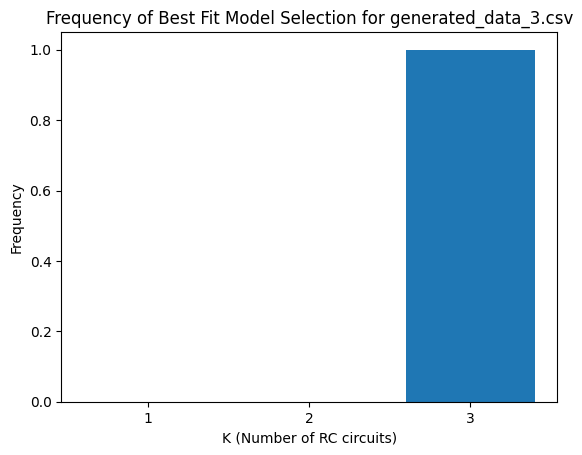

In [11]:
from tqdm import tqdm

custom_data_files = ["generated_data_3.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])


    wbic_values_n = []
    R_samples_n = []
    C_samples_n = []
    
    K_max = 3

    if file == "circuit1_data.csv" or file == "circuit2_data.csv":
        K_max = 2    
    K_n = np.zeros(K_max)
    for i in tqdm(range(50), desc=f"Finding best fit model for {file}"):
        best_model, wbic_values, R_samples, C_samples = find_best_fit_model(custom_frequencies, custom_Z_measured, sigma=10, n_iterations=220_000, K_max=K_max, burn_in=150_000)
        K_n[best_model - 1] += 1 
        R_samples_n.append(R_samples)
        C_samples_n.append(C_samples)

    K_best = np.argmax(K_n) + 1

    R_samples_n, C_samples_n = sort_samples(R_samples_n, C_samples_n)
    print(f"Best fit model for {file}: K = {K_best}\n")
    for j in range(K_max):
        for i in range(j + 1):
            print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[j][i]):.2f}")
            print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[j][i]):.2e}")
        print('')

    # Normalize K_n
    K_n = K_n / np.sum(K_n)
    print(K_n)

    # Plotting the bar chart of K_n
    plt.bar(range(1, K_max + 1), K_n)
    plt.xlabel('K (Number of RC circuits)')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Best Fit Model Selection for {file}')
    plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
    plt.show()

Finding best fit model for circuit1_data.csv: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]

Estimated R value for R[0]: 520.70
Estimated C value for C[0]: 1.55e-06

i: 1, x: 0
i: 1, x: 1
i: 1, x: 2
i: 1, x: 3
i: 1, x: 4
Estimated R value for R[1]: 140.28	530.32
Estimated R value for C[1]: 140.28	530.32

[0. 1.]


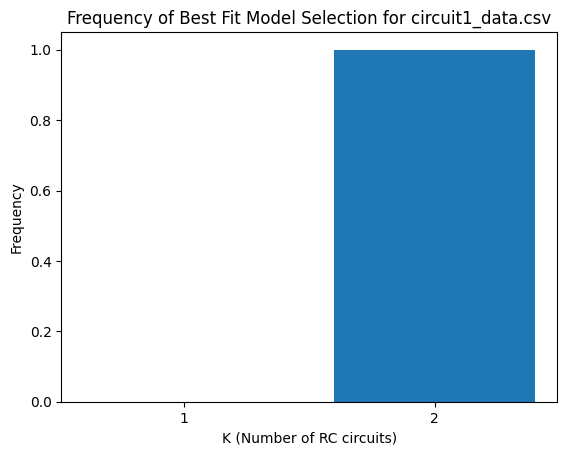

Finding best fit model for circuit2_data.csv: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it]

Estimated R value for R[0]: 542.97
Estimated C value for C[0]: 1.60e-06

i: 1, x: 0
i: 1, x: 1
i: 1, x: 2
i: 1, x: 3
i: 1, x: 4
Estimated R value for R[1]: 119.74	566.06
Estimated R value for C[1]: 119.74	566.06

[0. 1.]


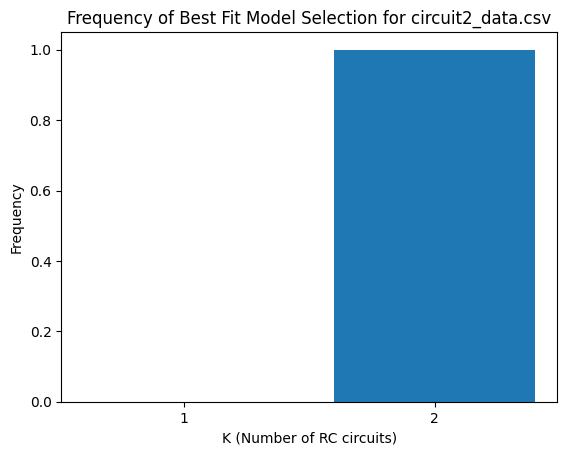

Finding best fit model for generated_data_1.csv:  60%|██████    | 3/5 [00:10<00:07,  3.58s/it]

In [ ]:
from tqdm import tqdm

custom_data_files = ["circuit1_data.csv", "circuit2_data.csv","generated_data_1.csv", "generated_data_2.csv", "generated_data_3.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])


    wbic_values_n = []
    R_samples_n = []
    C_samples_n = []
    
    K_max = 3

    if file == "circuit1_data.csv" or file == "circuit2_data.csv":
        K_max = 2    
    K_n = np.zeros(K_max)
    for i in tqdm(range(5), desc=f"Finding best fit model for {file}"):
        best_model, wbic_values, R_samples, C_samples = find_best_fit_model(custom_frequencies, custom_Z_measured, sigma=10, n_iterations=20_000, K_max=K_max, burn_in=10_000)
        K_n[best_model - 1] += 1

        R_samples_sorted, C_samples_sorted = sort_samples(R_samples, C_samples)
         
        for k in range (K_max):
            if k == 0:
                R_k = np.mean(R_samples_sorted[k])
                C_k = np.mean(C_samples_sorted[k])
            if k == 1:
                C_k = []
                R_k = []
                test = R_samples_sorted[k]
                r_value_0 = 0
                r_value_1 = 0
                c_value_0 = 0
                c_value_1 = 0
                for x in range(len(R_samples_sorted[k])):
                    r_value_0 += R_samples_sorted[k][x][0]
                    r_value_1 += R_samples_sorted[k][x][1]
                    c_value_0 += C_samples_sorted[k][x][0]
                    c_value_1 += C_samples_sorted[k][x][1]

                R_k = (r_value_0/len(R_samples_sorted[k]), r_value_1/len(R_samples_sorted[k]))
                C_k = (c_value_0/len(C_samples_sorted[k]), c_value_1/len(C_samples_sorted[k]))

                R_k, C_k = sort_linked_arrays_1d(R_k, C_k)
                # for i in range(len(R_samples_sorted[k])):
                # R_k = np.mean([sample[x] for sample in R_samples_sorted[k] if len(sample) > x])
                # R_k = (np.mean(R_samples_sorted[k][x][0]), np.mean(R_samples_sorted[k][x][1]))        

            else:
                pass
            if len(R_samples_n) < K_max:
                R_samples_n.extend([[] for _ in range(K_max - len(R_samples_n))])
            if len(C_samples_n) < K_max:
                C_samples_n.extend([[] for _ in range(K_max - len(C_samples_n))])
                       
            R_samples_n[k].append(R_k)
            C_samples_n[k].append(C_k)
       

    K_best = np.argmax(K_n) + 1
    
    for i in range(K_max):
        if i==0:
            print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[i]):.2f}")
            print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[i]):.2e}")
        if i==1:
            r_value_0 = 0
            r_value_1 = 0
            c_value_0 = 0
            c_value_1 = 0
            for x in range(len(R_samples_n[i])):
                print(f"i: {i}, x: {x}")
                r_value_0 += R_samples_n[i][x][0]
                r_value_1 += R_samples_n[i][x][1]
                c_value_0 += R_samples_n[i][x][0]
                c_value_1 += R_samples_n[i][x][1]
            R_1 = r_value_0/len(R_samples_n[i])
            R_2 = r_value_1/len(R_samples_n[i])
            C_1 = c_value_0/len(C_samples_n[i])
            C_2 = c_value_1/len(C_samples_n[i])

            
            print(f"Estimated R value for R[{i}]: {R_1:.2f}\t{R_2:.2f}")
            print(f"Estimated R value for C[{i}]: {C_1:.2f}\t{C_2:.2f}")
            # print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[i][0]):.2e}\t{np.mean(C_samples_n[i][1]):.2e}")
        print('')
    # R_samples_n, C_samples_n = sort_samples(R_samples_n, C_samples_n)
    # print(f"Best fit model for {file}: K = {K_best}\n")
    # for j in range(K_max):
    #     for i in range(j + 1):
    #         print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[j][i]):.2f}")
    #         print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[j][i]):.2e}")
    #     print('')

    # Normalize K_n
    K_n = K_n / np.sum(K_n)
    print(K_n)

    # Plotting the bar chart of K_n
    plt.bar(range(1, K_max + 1), K_n)
    plt.xlabel('K (Number of RC circuits)')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Best Fit Model Selection for {file}')
    plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
    plt.show()

Finding best fit model for circuit1_data.csv: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it]

Best fit model for circuit1_data.csv: K = 2

Estimated R value for R[0]: 334.65
Estimated C value for C[0]: 1.34e-06

Estimated R value for R[0]: 279.25
Estimated C value for C[0]: 4.05e-06
Estimated R value for R[1]: 520.84
Estimated C value for C[1]: 1.54e-06

[0. 1.]


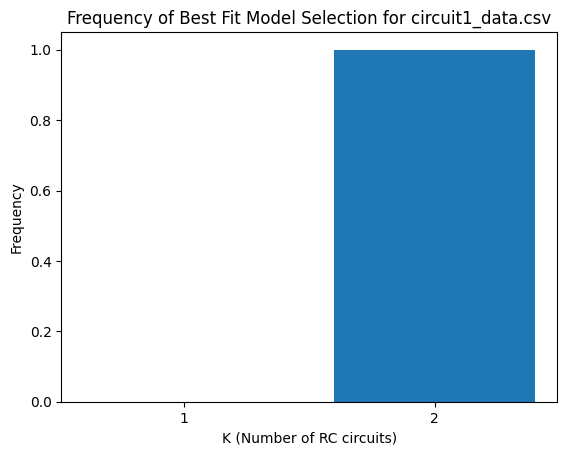

Finding best fit model for circuit2_data.csv: 100%|██████████| 50/50 [02:04<00:00,  2.49s/it]

Best fit model for circuit2_data.csv: K = 2

Estimated R value for R[0]: 301.56
Estimated C value for C[0]: 3.70e-06

Estimated R value for R[0]: 338.95
Estimated C value for C[0]: 1.31e-06
Estimated R value for R[1]: 543.20
Estimated C value for C[1]: 1.61e-06

[0. 1.]


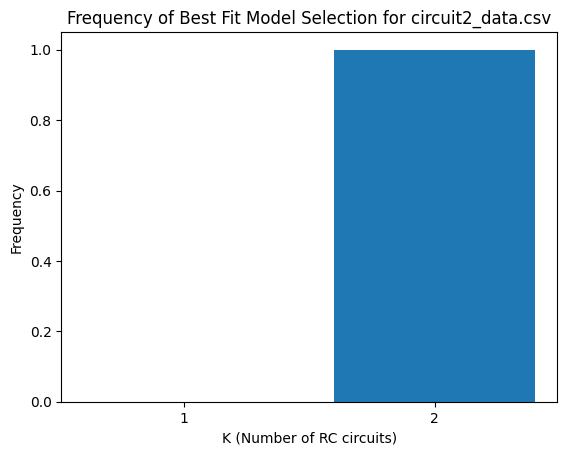

Finding best fit model for generated_data_1.csv: 100%|██████████| 50/50 [03:54<00:00,  4.69s/it]

Best fit model for generated_data_1.csv: K = 1

Estimated R value for R[0]: 497.68
Estimated C value for C[0]: 3.13e-06

Estimated R value for R[0]: 498.06
Estimated C value for C[0]: 3.48e-06
Estimated R value for R[1]: 746.15
Estimated C value for C[1]: 1.06e-06

Estimated R value for R[0]: 746.11
Estimated C value for C[0]: 1.64e-06
Estimated R value for R[1]: 498.20
Estimated C value for C[1]: 4.16e-06
Estimated R value for R[2]: 1489.83
Estimated C value for C[2]: 5.00e-07

[0.6  0.38 0.02]


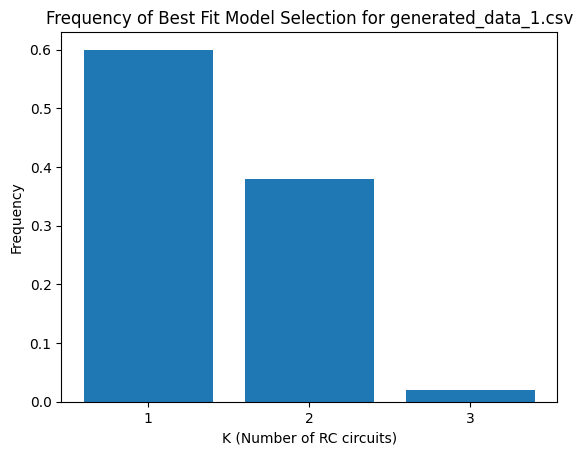

Finding best fit model for generated_data_2.csv: 100%|██████████| 50/50 [03:55<00:00,  4.72s/it]

Best fit model for generated_data_2.csv: K = 2

Estimated R value for R[0]: 1938.74
Estimated C value for C[0]: 1.16e-06

Estimated R value for R[0]: 1938.69
Estimated C value for C[0]: 1.86e-06
Estimated R value for R[1]: 2907.70
Estimated C value for C[1]: 7.52e-07

Estimated R value for R[0]: 2907.58
Estimated C value for C[0]: 7.52e-07
Estimated R value for R[1]: 1939.54
Estimated C value for C[1]: 2.76e-06
Estimated R value for R[2]: 5332.81
Estimated C value for C[2]: 5.82e-07

[0.   0.96 0.04]


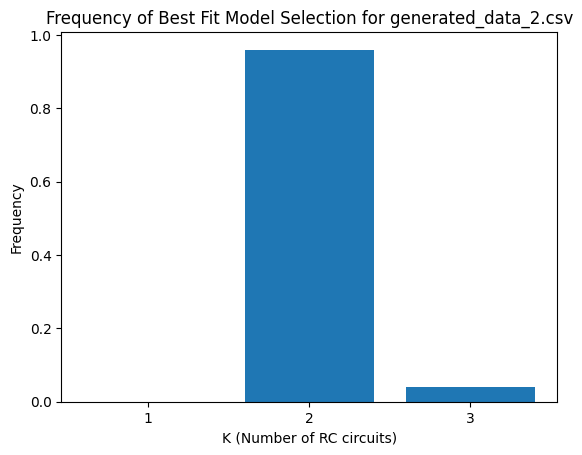

Finding best fit model for generated_data_3.csv: 100%|██████████| 50/50 [03:31<00:00,  4.23s/it]

Best fit model for generated_data_3.csv: K = 3

Estimated R value for R[0]: 4063.40
Estimated C value for C[0]: 4.57e-06

Estimated R value for R[0]: 4035.21
Estimated C value for C[0]: 3.37e-06
Estimated R value for R[1]: 6040.32
Estimated C value for C[1]: 1.93e-06

Estimated R value for R[0]: 4063.08
Estimated C value for C[0]: 4.15e-06
Estimated R value for R[1]: 6043.33
Estimated C value for C[1]: 1.94e-06
Estimated R value for R[2]: 9999.94
Estimated C value for C[2]: 8.79e-07

[0.   0.14 0.86]


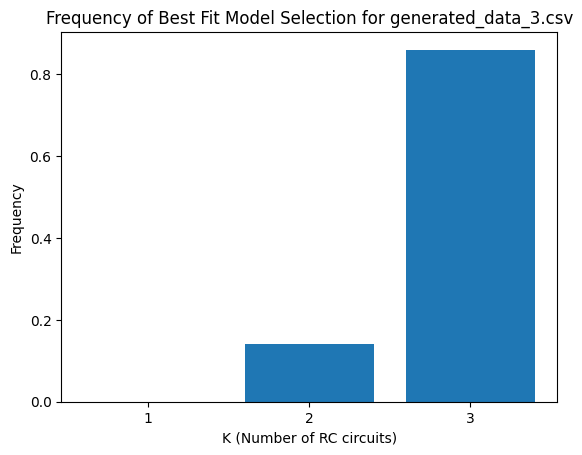

In [ ]:
from tqdm import tqdm

custom_data_files = ["circuit1_data.csv", "circuit2_data.csv","generated_data_1.csv", "generated_data_2.csv", "generated_data_3.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])


    wbic_values_n = []
    R_samples_n = []
    C_samples_n = []
    
    K_max = 3

    if file == "circuit1_data.csv" or file == "circuit2_data.csv":
        K_max = 2    
    K_n = np.zeros(K_max)
    for i in tqdm(range(50), desc=f"Finding best fit model for {file}"):
        best_model, wbic_values, R_samples, C_samples = find_best_fit_model(custom_frequencies, custom_Z_measured, sigma=10, n_iterations=40_000, K_max=K_max, burn_in=30_000)
        K_n[best_model - 1] += 1 
        R_samples_n.append(R_samples)
        C_samples_n.append(C_samples)

    K_best = np.argmax(K_n) + 1

    R_samples_n, C_samples_n = sort_samples(R_samples_n, C_samples_n)
    print(f"Best fit model for {file}: K = {K_best}\n")
    for j in range(K_max):
        for i in range(j + 1):
            print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[j][i]):.2f}")
            print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[j][i]):.2e}")
        print('')

    # Normalize K_n
    K_n = K_n / np.sum(K_n)
    print(K_n)

    # Plotting the bar chart of K_n
    plt.bar(range(1, K_max + 1), K_n)
    plt.xlabel('K (Number of RC circuits)')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Best Fit Model Selection for {file}')
    plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
    plt.show()

Finding best fit model for circuit1_data.csv:   0%|          | 0/50 [00:00<?, ?it/s]

Finding best fit model for circuit1_data.csv: 100%|██████████| 50/50 [04:02<00:00,  4.85s/it]

Best fit model for circuit1_data.csv: K = 2

Estimated R value for R[0]: 333.79
Estimated C value for C[0]: 1.33e-06

Estimated R value for R[0]: 520.78
Estimated C value for C[0]: 1.54e-06
Estimated R value for R[1]: 333.44
Estimated C value for C[1]: 1.32e-06

[0. 1.]


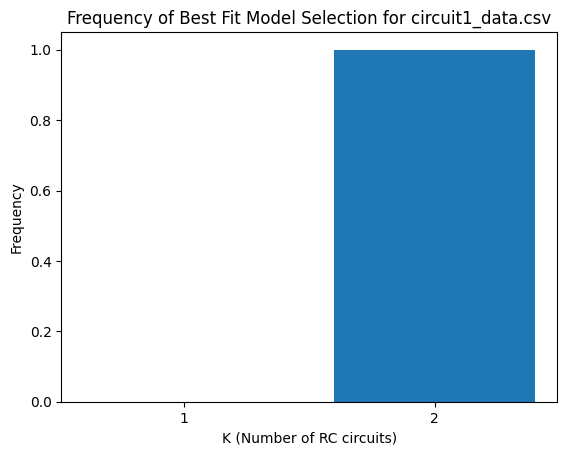

Finding best fit model for circuit2_data.csv: 100%|██████████| 50/50 [03:57<00:00,  4.76s/it]

Best fit model for circuit2_data.csv: K = 2

Estimated R value for R[0]: 542.42
Estimated C value for C[0]: 1.60e-06

Estimated R value for R[0]: 542.77
Estimated C value for C[0]: 1.60e-06
Estimated R value for R[1]: 338.23
Estimated C value for C[1]: 1.32e-06

[0. 1.]


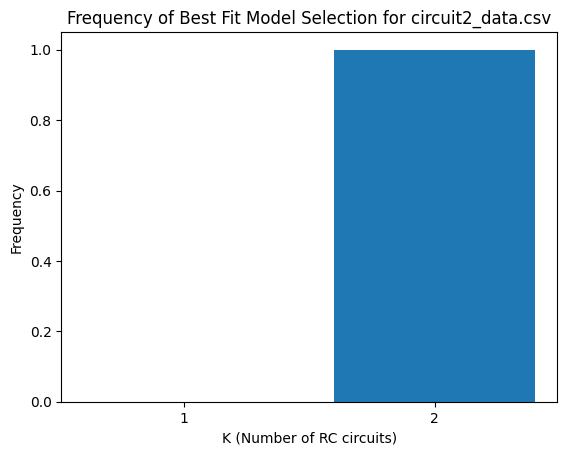

Finding best fit model for generated_data_1.csv: 100%|██████████| 50/50 [07:39<00:00,  9.18s/it]

Best fit model for generated_data_1.csv: K = 1

Estimated R value for R[0]: 497.76
Estimated C value for C[0]: 3.88e-06

Estimated R value for R[0]: 497.96
Estimated C value for C[0]: 4.95e-06
Estimated R value for R[1]: 745.75
Estimated C value for C[1]: 2.61e-06

Estimated R value for R[0]: 746.76
Estimated C value for C[0]: 4.42e-06
Estimated R value for R[1]: 498.35
Estimated C value for C[1]: 3.96e-06
Estimated R value for R[2]: 1489.80
Estimated C value for C[2]: 4.99e-07

[0.64 0.3  0.06]


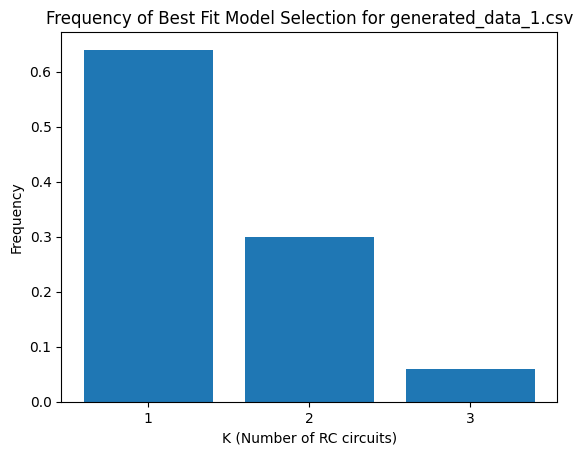

Finding best fit model for generated_data_2.csv: 100%|██████████| 50/50 [07:44<00:00,  9.29s/it]

Best fit model for generated_data_2.csv: K = 2

Estimated R value for R[0]: 1938.49
Estimated C value for C[0]: 3.43e-06

Estimated R value for R[0]: 1938.55
Estimated C value for C[0]: 2.99e-06
Estimated R value for R[1]: 2907.99
Estimated C value for C[1]: 7.52e-07

Estimated R value for R[0]: 1939.09
Estimated C value for C[0]: 3.31e-06
Estimated R value for R[1]: 2908.26
Estimated C value for C[1]: 7.52e-07
Estimated R value for R[2]: 5334.45
Estimated C value for C[2]: 5.82e-07

[0.   0.94 0.06]


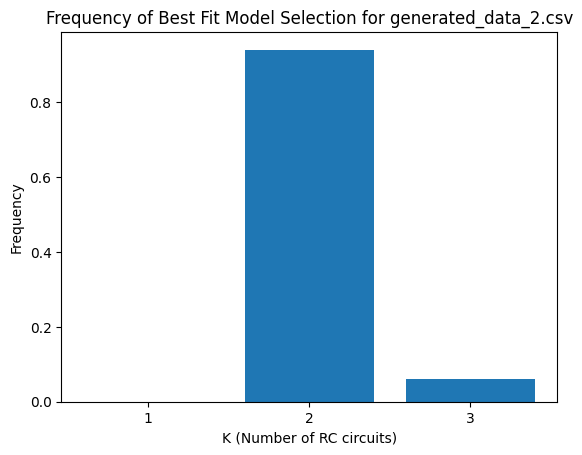

Finding best fit model for generated_data_3.csv: 100%|██████████| 50/50 [06:55<00:00,  8.30s/it]

Best fit model for generated_data_3.csv: K = 3

Estimated R value for R[0]: 6044.08
Estimated C value for C[0]: 1.95e-06

Estimated R value for R[0]: 4065.02
Estimated C value for C[0]: 4.05e-06
Estimated R value for R[1]: 6045.15
Estimated C value for C[1]: 1.96e-06

Estimated R value for R[0]: 4064.45
Estimated C value for C[0]: 3.43e-06
Estimated R value for R[1]: 6043.33
Estimated C value for C[1]: 1.94e-06
Estimated R value for R[2]: 9999.96
Estimated C value for C[2]: 8.80e-07

[0.   0.02 0.98]


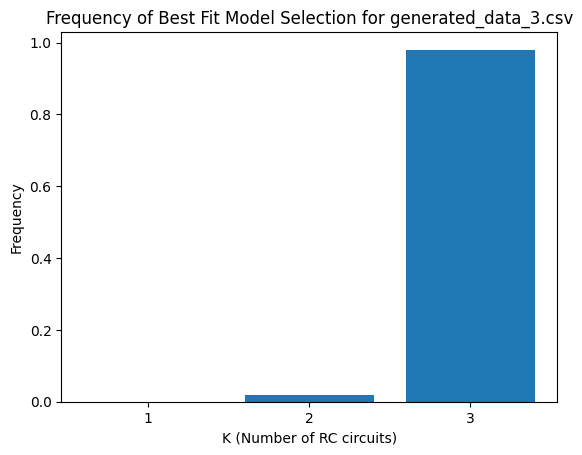

In [23]:
from tqdm import tqdm

custom_data_files = ["circuit1_data.csv", "circuit2_data.csv","generated_data_1.csv", "generated_data_2.csv", "generated_data_3.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])


    wbic_values_n = []
    R_samples_n = []
    C_samples_n = []
    
    K_max = 3

    if file == "circuit1_data.csv" or file == "circuit2_data.csv":
        K_max = 2    
    K_n = np.zeros(K_max)
    for i in tqdm(range(50), desc=f"Finding best fit model for {file}"):
        best_model, wbic_values, R_samples, C_samples = find_best_fit_model(custom_frequencies, custom_Z_measured, sigma=10, n_iterations=80_000, K_max=K_max, burn_in=70_000)
        K_n[best_model - 1] += 1 
        R_samples_n.append(R_samples)
        C_samples_n.append(C_samples)

    K_best = np.argmax(K_n) + 1

    R_samples_n, C_samples_n = sort_samples(R_samples_n, C_samples_n)
    print(f"Best fit model for {file}: K = {K_best}\n")
    for j in range(K_max):
        for i in range(j + 1):
            print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[j][i]):.2f}")
            print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[j][i]):.2e}")
        print('')

    # Normalize K_n
    K_n = K_n / np.sum(K_n)
    print(K_n)

    # Plotting the bar chart of K_n
    plt.bar(range(1, K_max + 1), K_n)
    plt.xlabel('K (Number of RC circuits)')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Best Fit Model Selection for {file}')
    plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
    plt.show()

Finding best fit model for circuit1_data.csv: 100%|██████████| 500/500 [30:38<00:00,  3.68s/it]

Best fit model for circuit1_data.csv: K = 1

Estimated R value for R[0]: 341.54
Estimated C value for C[0]: 2.06e-06

Estimated R value for R[0]: 533.18
Estimated C value for C[0]: 1.58e-06
Estimated R value for R[1]: 553.98
Estimated C value for C[1]: 4.43e-06

[0.674 0.326]


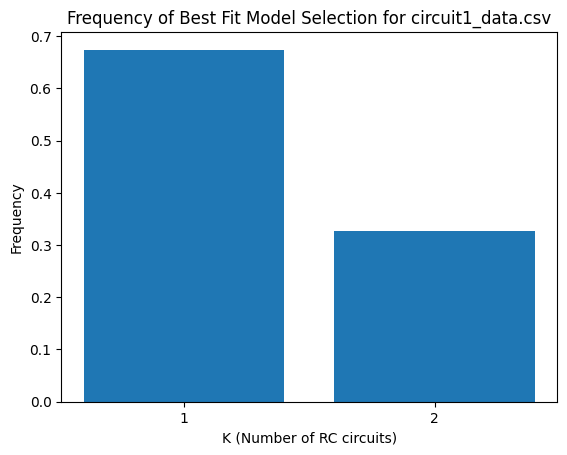

Finding best fit model for circuit2_data.csv: 100%|██████████| 500/500 [29:27<00:00,  3.53s/it]

Best fit model for circuit2_data.csv: K = 1

Estimated R value for R[0]: 596.60
Estimated C value for C[0]: 1.63e-06

Estimated R value for R[0]: 562.33
Estimated C value for C[0]: 2.03e-06
Estimated R value for R[1]: 403.88
Estimated C value for C[1]: 1.35e-06

[0.678 0.322]


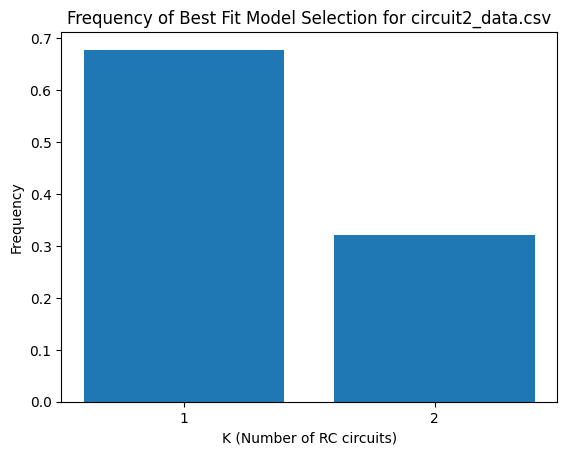

Finding best fit model for generated_data_1.csv: 100%|██████████| 500/500 [57:19<00:00,  6.88s/it]

Best fit model for generated_data_1.csv: K = 1

Estimated R value for R[0]: 508.59
Estimated C value for C[0]: 2.66e-06

Estimated R value for R[0]: 532.37
Estimated C value for C[0]: 5.30e-06
Estimated R value for R[1]: 863.84
Estimated C value for C[1]: 2.06e-06

Estimated R value for R[0]: 765.59
Estimated C value for C[0]: 4.54e-06
Estimated R value for R[1]: 1564.13
Estimated C value for C[1]: 6.69e-07
Estimated R value for R[2]: 588.56
Estimated C value for C[2]: 4.95e-06

[0.644 0.272 0.084]


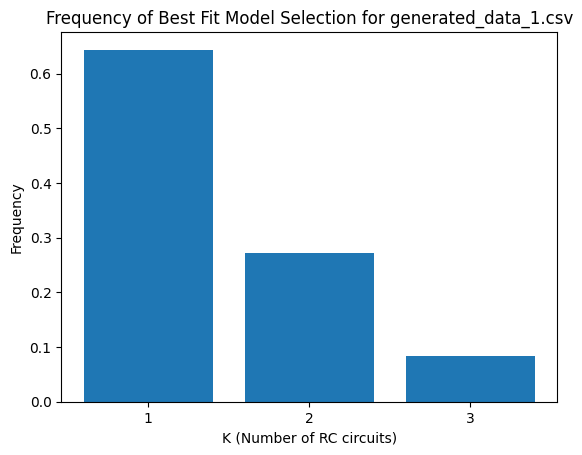

Finding best fit model for generated_data_2.csv: 100%|██████████| 500/500 [53:50<00:00,  6.46s/it]

Best fit model for generated_data_2.csv: K = 3

Estimated R value for R[0]: 3733.92
Estimated C value for C[0]: 3.28e-06

Estimated R value for R[0]: 5557.77
Estimated C value for C[0]: 4.56e-06
Estimated R value for R[1]: 3779.95
Estimated C value for C[1]: 4.88e-06

Estimated R value for R[0]: 3736.25
Estimated C value for C[0]: 3.50e-06
Estimated R value for R[1]: 5651.55
Estimated C value for C[1]: 3.83e-06
Estimated R value for R[2]: 9988.20
Estimated C value for C[2]: 3.41e-07

[0.022 0.476 0.502]


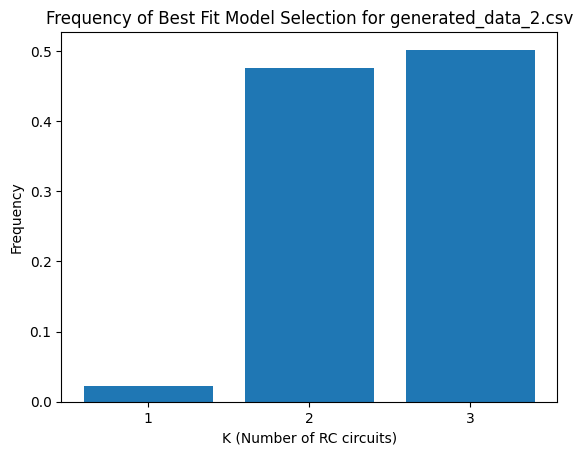

Finding best fit model for generated_data_3.csv: 100%|██████████| 500/500 [51:06<00:00,  6.13s/it]

Best fit model for generated_data_3.csv: K = 3

Estimated R value for R[0]: 4054.63
Estimated C value for C[0]: 4.25e-06

Estimated R value for R[0]: 9763.98
Estimated C value for C[0]: 9.12e-07
Estimated R value for R[1]: 6029.00
Estimated C value for C[1]: 2.07e-06

Estimated R value for R[0]: 4062.91
Estimated C value for C[0]: 4.19e-06
Estimated R value for R[1]: 6037.36
Estimated C value for C[1]: 2.20e-06
Estimated R value for R[2]: 9997.40
Estimated C value for C[2]: 8.73e-07

[0.    0.334 0.666]


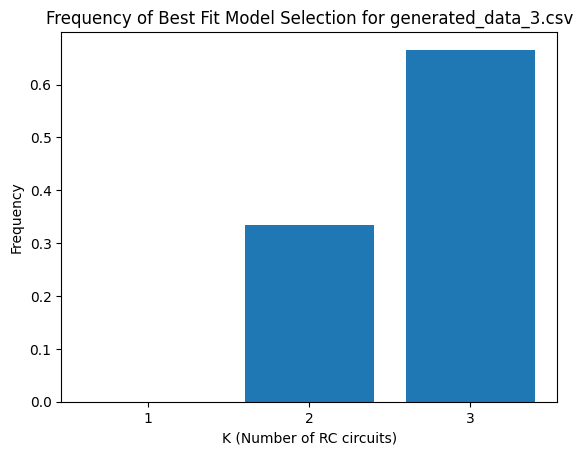

In [ ]:
from tqdm import tqdm

custom_data_files = ["circuit1_data.csv", "circuit2_data.csv","generated_data_1.csv", "generated_data_2.csv", "generated_data_3.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])


    wbic_values_n = []
    R_samples_n = []
    C_samples_n = []
    
    K_max = 3

    if file == "circuit1_data.csv" or file == "circuit2_data.csv":
        K_max = 2    
    K_n = np.zeros(K_max)
    for i in tqdm(range(500), desc=f"Finding best fit model for {file}"):
        best_model, wbic_values, R_samples, C_samples = find_best_fit_model(custom_frequencies, custom_Z_measured, sigma=10, n_iterations=50_000, K_max=K_max, burn_in=1000)
        K_n[best_model - 1] += 1 
        R_samples_n.append(R_samples)
        C_samples_n.append(C_samples)

    K_best = np.argmax(K_n) + 1

    R_samples_n, C_samples_n = sort_samples(R_samples_n, C_samples_n)
    print(f"Best fit model for {file}: K = {K_best}\n")
    for j in range(K_max):
        for i in range(j + 1):
            print(f"Estimated R value for R[{i}]: {np.mean(R_samples_n[j][i]):.2f}")
            print(f"Estimated C value for C[{i}]: {np.mean(C_samples_n[j][i]):.2e}")
        print('')

    # Normalize K_n
    K_n = K_n / np.sum(K_n)
    print(K_n)

    # Plotting the bar chart of K_n
    plt.bar(range(1, K_max + 1), K_n)
    plt.xlabel('K (Number of RC circuits)')
    plt.ylabel('Frequency')
    plt.title(f'Frequency of Best Fit Model Selection for {file}')
    plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
    plt.show()

In [16]:
# # Define function for Nyquist plots
# def plot_nyquist(ax, real, imag, color1, color2, color3, title):
#     complex_values = real + 1j * imag
#     ax.plot(complex_values.real, complex_values.imag, color=color1, label='Nyquist Path')
#     ax.plot(complex_values.real, -complex_values.imag, color=color2, linestyle='--', label='Mirror Path')
#     ax.scatter(complex_values.real, complex_values.imag, color=color3, label='Points')
#     ax.set_xlabel('Real Part')
#     ax.set_ylabel('Imaginary Part')
#     ax.set_title(title)
#     ax.legend()


# # Create subplots
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Plot for each subplot
# plot_nyquist(axs[0], real_circuit1, imag_circuit1, "blue", "green", "aqua", "Nyquist Plot: Circuit 1")
# plot_nyquist(axs[0], real_circuit2, imag_circuit2, "orange", "red", "yellow", "Nyquist Plot: Circuit 2")
# axs[0].set_title('Nyquist Plot: Circuit 1 and 2')

# plot_nyquist(axs[1], real_circuit1, imag_circuit1, "blue", "green", "aqua", "Nyquist Plot: Circuit 1")
# plot_nyquist(axs[2], real_circuit2, imag_circuit2, "orange", "red", "yellow", "Nyquist Plot: Circuit 2")

# # Add global grid and axis lines
# for ax in axs:
#     ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
#     ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
#     ax.grid()

# plt.tight_layout()
# plt.show()

In [17]:
# from numpy import load

# circuit1_npz = load('./Circuit1/spectrum-f_min_0-f_max_12501-f_step_250.npz')
# circuit2_npz = load('./Circuit2/spectrum-f_min_0-f_max_12501-f_step_250.npz')

# circuit1_npz_array = circuit1_npz['arr_0']
# circuit2_npz_array = circuit2_npz['arr_0']

# with open(f'circuit1_data.csv', 'w') as f:
#         f.write('Frequency,Z_real,Z_imag\n')
# with open(f'circuit2_data.csv', 'w') as f:
#         f.write('Frequency,Z_real,Z_imag\n')

# for i in range(0, len(circuit1_npz_array)):
#     frequency = i * 250
#     with open(f'circuit1_data.csv', 'a') as f:
#         real_part = circuit1_npz_array[i][0].real
#         imag_part = circuit1_npz_array[i][0].imag
#         f.write(f"{frequency},{real_part},{imag_part}\n")

#     with open(f'circuit2_data.csv', 'a') as f:
#         real_part = circuit2_npz_array[i][0].real
#         imag_part = circuit2_npz_array[i][0].imag
#         f.write(f"{frequency},{real_part},{imag_part}\n")

In [18]:
# import numpy as np

# R_n_3 = [1500, 7500, 3200]
# C_n_3 = [500e-9, 5e-4, 2e-6]

# R_n_2 = [800, 5000]
# C_n_2 = [500e-9, 1e-6]

# R_n_1 = [1500,]
# C_n_1 = [500e-9]

# frequency_n = np.arange(0, 12501, 250)

# for i, (R, C) in enumerate([(R_n_1, C_n_1), (R_n_2, C_n_2), (R_n_3, C_n_3)], start=1):
#     Z_n = circuit_impedance(frequency_n, R, C)
#     noise_real = np.random.normal(0, 10, len(frequency_n))
#     noise_imag = np.random.normal(0, 10, len(frequency_n))
#     Z_n += noise_real + 1j * noise_imag
#     df = pd.DataFrame({
#         'Frequency': frequency_n,
#         'Z_real': np.real(Z_n),
#         'Z_imag': np.imag(Z_n)
#     })
#     df.to_csv(f'generated_data_{i}.csv', index=False)

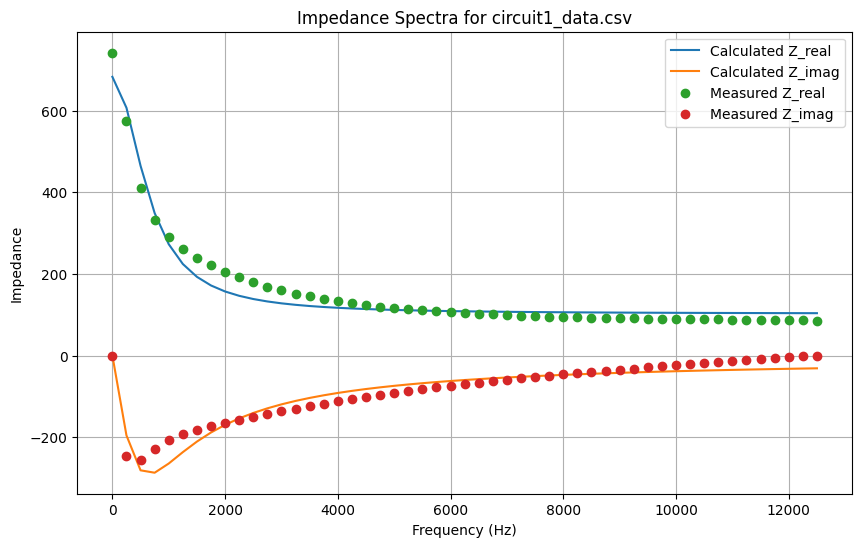

In [17]:
custom_data_files = ["circuit1_data.csv"]

for file in custom_data_files:
    custom_data = pd.read_csv(file)
    custom_frequencies = custom_data['Frequency']  # Hz
    custom_Z_measured = np.array(custom_data['Z_real']) + 1j * np.array(custom_data['Z_imag'])

    R_n = [520.78, 333.44]
    C_n = [ 1.32e-6, 1.54e-6]

    R_n = [580.6293542669868, 102.27302946920597]
    C_n = [2.671372393361953e-06, 1.0917997691140967e-08]
    

    impedance_values = circuit_impedance(custom_frequencies, R_n, C_n)

    plt.figure(figsize=(10, 6))
    plt.plot(custom_frequencies, np.real(impedance_values), label='Calculated Z_real')
    plt.plot(custom_frequencies, np.imag(impedance_values), label='Calculated Z_imag')
    plt.plot(custom_frequencies, np.real(custom_Z_measured), 'o', label='Measured Z_real')
    plt.plot(custom_frequencies, np.imag(custom_Z_measured), 'o', label='Measured Z_imag')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance')
    plt.title(f'Impedance Spectra for {file}')
    plt.legend()
    plt.grid()
    plt.show()

